(example_1)=
# Example 1: Bayesian filtering of cardiac volatility

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_1_Heart_rate_variability.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf systole

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from bokeh.io import output_notebook
from bokeh.plotting import show
from systole import import_dataset1
from systole.detection import ecg_peaks
from systole.plots import plot_raw
from systole.utils import input_conversion

from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import total_gaussian_surprise

In [2]:
output_notebook()

Loading BokehJS ...

The nodalized version of the Hierarchical Gaussian Filter that is implemented in [pyhgf](https://github.com/ilabcode/pyhgf) opens the possibility to create filters with multiple inputs. Here, we illustrate how we can use this feature to create an agent that is filtering their physiological signals in real-time. We use a two-level Hierarchical Gaussian Filter to predict the dynamics of the instantaneous heart rate (the RR interval measured at each heartbeat). We then extract the trajectory of surprise at each predictive node to relate it with the cognitive task performed by the participant while the signal is being recorded.

## Loading and preprocessing physiological recording
We use the physiological dataset included in [Systole](https://embodied-computation-group.github.io/systole/index.html) as an example. This recording contains electrocardiography (ECG) and respiration recording.

In [3]:
# Import PPG recording as pandas data frame
physio_df = import_dataset1(modalities=['ECG', 'Respiration'])

# Only use the first 60 seconds for demonstration
ecg = physio_df.ecg

### Plot the signal with instantaneous heart rate derivations

In [4]:
show(
    plot_raw(ecg, modality='ecg', sfreq=1000, show_heart_rate=True, backend="bokeh")
)

### Preprocessing

In [5]:
# detect R peaks using Pan-Tomkins algorithm
_, peaks = ecg_peaks(physio_df.ecg)

# convert the peaks into a RR time series
rr = input_conversion(x=peaks, input_type="peaks", output_type="rr_s")

## Model

```{note}
Here we use the total Gaussian surprise ({py:func}`pyhgf.response.total_gaussian_surprise`) as a response function. This response function deviates from the default behaviour for the continuous HGF in that it returns the sum of the surprise for all the probabilistic nodes in the network, whereas the default ({py:func}`pyhgf.response.first_level_gaussian_surprise`) only computes the surprise at the first level (i.e. the value parent of the continuous input node). We explicitly specify this parameter here to indicate that we want our model to minimise its prediction errors over all variables, and not only at the observation level. In this case, however, the results are expected to be very similar between the two methods.
```

In [6]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=[rr],
    response_function=total_gaussian_surprise,
)

In [7]:
with pm.Model() as three_level_hgf:

    # omegas priors
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -2.0, 2.0)

    # HGF distribution
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_1=-4.0, tonic_volatility_2=tonic_volatility_2))

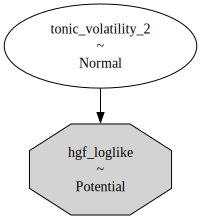

In [8]:
pm.model_to_graphviz(three_level_hgf)

In [9]:
with three_level_hgf:
    idata = pm.sample(chains=2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


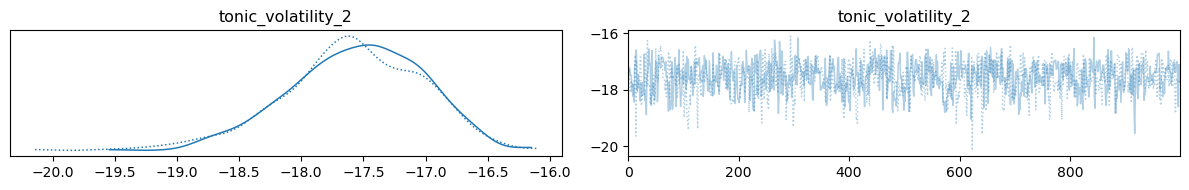

In [10]:
az.plot_trace(idata)
plt.tight_layout()

In [11]:
# retrieve the best fir for omega_2
tonic_volatility_2 = az.summary(idata)["mean"]["tonic_volatility_2"]

In [12]:
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mean={"1": rr[0], "2": -4.0},
    initial_precision={"1": 1e4, "2": 1e1},
    tonic_volatility={"1": -4.0, "2": tonic_volatility_2},
    tonic_drift={"1": 0.0, "2": 0.0},
    volatility_coupling={"1": 1.0}).input_data(input_data=rr)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 1935 new observations.


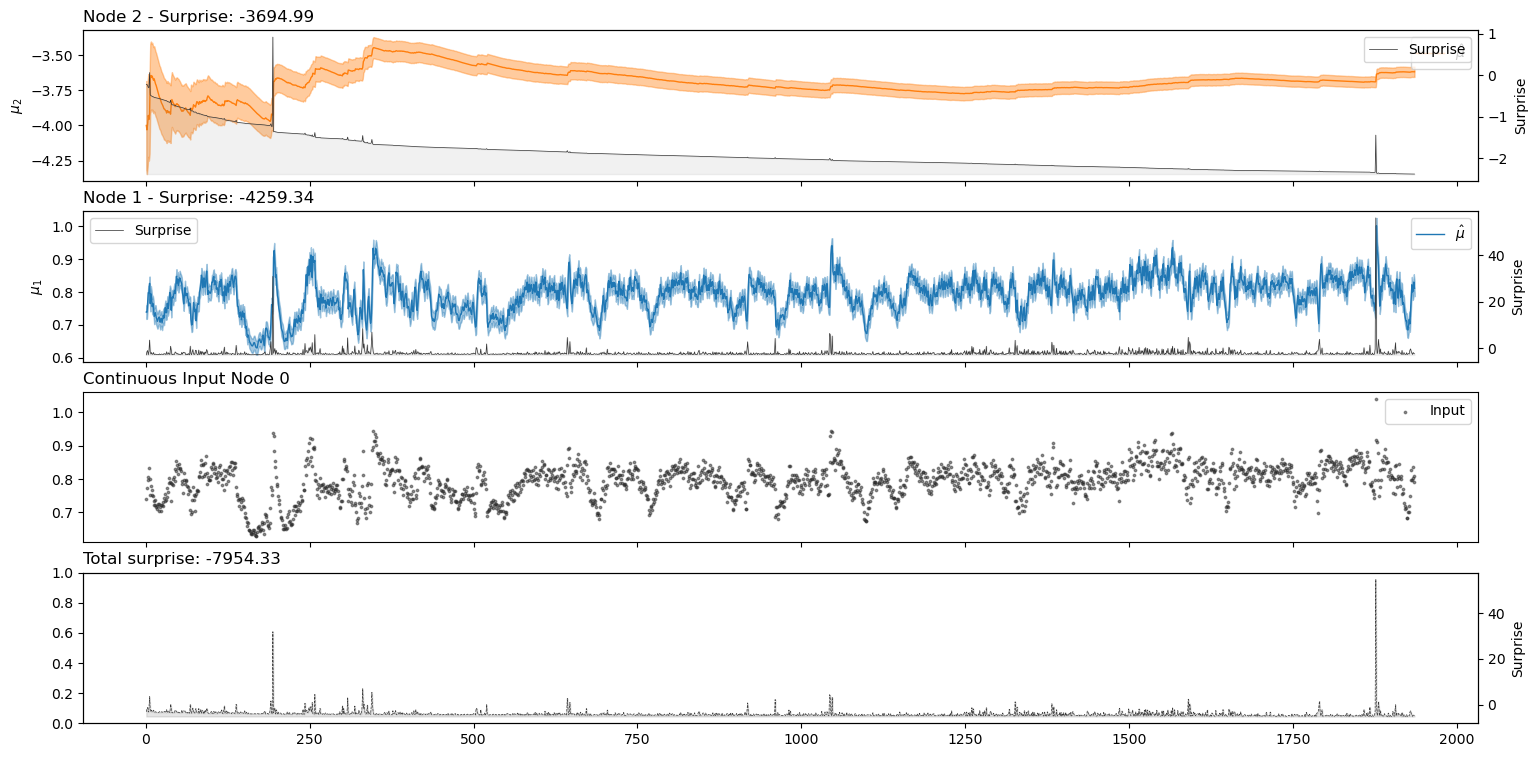

In [13]:
hgf.plot_trajectories();

# System configuration

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Nov 06 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.9
jax   : 0.4.14
jaxlib: 0.4.14

pymc      : 5.5.0
matplotlib: 3.7.1
arviz     : 0.16.1
seaborn   : 0.12.2
numpy     : 1.22.0
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]

Watermark: 2.4.3

